In [310]:
# Importing modules
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from sklearn.cluster import KMeans

In [311]:
# Read Excel file into database
df = pd.read_excel('RollerCoasterData.xlsx',
                                  index_col=False,
                                  keep_default_na=True
                                 )
df.head(50)

,Name,Park,City/Region,City/State/Region,Country/Region,Geographic Region,Construction,Type,Status,Year/Date Opened,Height (feet),Speed (mph),Length (feet),Inversions (YES or NO),Number of Inversions,Drop (feet),Duration (min:sec),G Force,Vertical Angle (degrees)
0,10 Inversion Roller Coaster,Chimelong Paradise,Panyu,"Guangzhou, Guangdong",China,Asia,Steel,Sit Down,Operating,2006.0,98.4,45.0,2788.8,YES,10.0,NaN,01:32:00,NaN,NaN
1,Abismo,Parque de Atracciones de Madrid,Madrid,Madrid,Spain,Europe,Steel,Sit Down,Operating,2006.0,151.6,65.2,1476.4,YES,2.0,NaN,01:00:00,4.0,NaN
2,Adrenaline Peak,Oaks Amusement Park,Portland,Oregon,United States,North America,Steel,Sit Down,Operating,2018.0,72,45.0,1050.0,YES,3.0,NaN,NaN,NaN,97.0
3,Afterburn,Carowinds,Charlotte,North Carolina,United States,North America,Steel,Inverted,Operating,1999.0,113,62.0,2956.0,YES,6.0,NaN,02:47:00,NaN,NaN
4,Alpengeist,Busch Gardens Williamsburg,Williamsburg,Virginia,United States,North America,Steel,Inverted,Operating,1997.0,195,67.0,3828.0,YES,6.0,170.0,03:10:00,3.7,NaN
5,Alpina Blitz,Nigloland,Dolancourt,Champagne-Ardenne,France,Europe,Steel,Sit Down,Operating,2014.0,108.3,51.6,2358.9,NO,0.0,NaN,NaN,4.3,NaN
6,Altair,Cinecittà World,Rome,Rome,Italy,Europe,Steel,Sit Down,Operating,2014.0,108.3,52.8,2879.8,YES,10.0,NaN,NaN,NaN,NaN
7,American Eagle,Six Flags Great America,Gurnee,Illinois,United States,North America,Wood,Sit Down,Operating,1981.0,127,66.0,4650.0,NO,0.0,147.0,02:23:00,NaN,55.0
8,Anaconda,Walygator Parc,Maizieres-les-Metz,Lorraine,France,Europe,Wood,Sit Down,Operating,1989.0,118.1,55.9,3937.0,NO,0.0,40.0,02:10:00,NaN,NaN
9,Apocalypse,Six Flags America,Upper Marlboro,Maryland,United States,North America,Steel,Stand Up,Operating,2012.0,100,55.0,2900.0,YES,2.0,90.0,02:00:00,NaN,NaN


In [312]:
# Clean up data

# Delete primary data source links
df = df[:-5]

names = df.Name.copy()
for index, row in df.iterrows():
    # Rename roller coasters with the same name to include their park
    if (names == row.Name).sum() > 1:
        df.at[index, 'Name'] = row.Name + ' (' + row.Park + ')'
    
    # Change Construction strings to numbers
    if 'Wood' in row['Construction']:
        df.at[index, 'Construction'] = 1
    elif 'Steel' in row['Construction']:
        df.at[index, 'Construction'] = 2

    # Convert height to float
    if isinstance(row['Height (feet)'], str):
        df.at[index, 'Height (feet)'] = float(row['Height (feet)'].split()[0])
        
    # Convert Duration to seconds
    if not pd.isna(row['Duration (min:sec)']):
        df.at[index, 'Duration (min:sec)'] = row['Duration (min:sec)'].hour * 60 + row['Duration (min:sec)'].minute

df['Height (feet)'] = df['Height (feet)'].astype(float)
df['Speed (mph)'] = df['Speed (mph)'].astype(float)
df['Construction'] = df['Construction'].astype(int)

# Delete unneeded columns
df.drop('Park', axis=1, inplace=True)
df.drop('City/Region', axis=1, inplace=True)
df.drop('City/State/Region', axis=1, inplace=True)
df.drop('Country/Region', axis=1, inplace=True)
df.drop('Geographic Region', axis=1, inplace=True)
df.drop('Status', axis=1, inplace=True)
df.drop('Year/Date Opened', axis=1, inplace=True)
df.drop('Type', axis=1, inplace=True)
df.drop('Inversions (YES or NO)', axis=1, inplace=True)

Pearson's Correlation: 0.9462904552196303


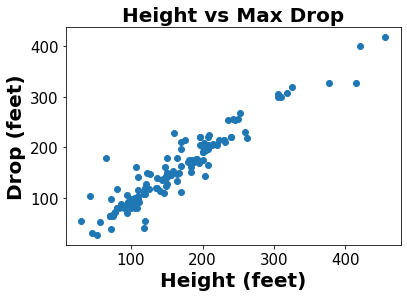

In [314]:
# Compare height vs max drop variables
heightDrop = df[['Height (feet)', 'Drop (feet)']].dropna()

corr, _ = pearsonr(heightDrop['Height (feet)'], heightDrop['Drop (feet)'])
print('Pearson\'s Correlation:', corr)

plt.scatter(heightDrop['Height (feet)'], heightDrop['Drop (feet)'])
plt.xlabel('Height (feet)', fontsize=20, weight='bold')
plt.ylabel('Drop (feet)', fontsize=20, weight='bold')
plt.title('Height vs Max Drop', fontsize=20, weight='bold')
plt.rc('font', size=15)
plt.show()

In [315]:
# Delete one of the variables since they are similar
df.drop('Drop (feet)', axis=1, inplace=True)

Pearson's Correlation: 0.620222832260476


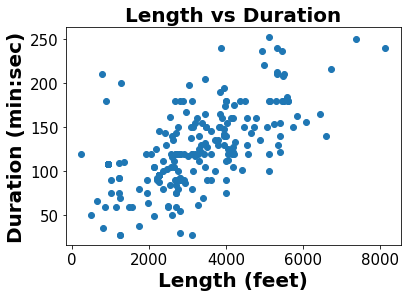

In [316]:
# Compare length vs duration variables
lengthDuration = df[['Length (feet)', 'Duration (min:sec)']].dropna()

corr, _ = pearsonr(lengthDuration['Length (feet)'], lengthDuration['Duration (min:sec)'])
print('Pearson\'s Correlation:', corr)

plt.scatter(lengthDuration['Length (feet)'], lengthDuration['Duration (min:sec)'])
plt.xlabel('Length (feet)', fontsize=20, weight='bold')
plt.ylabel('Duration (min:sec)', fontsize=20, weight='bold')
plt.title('Length vs Duration', fontsize=20, weight='bold')
plt.rc('font', size=15)
plt.show()

In [317]:
# Delete one of the variables since they are similar
df.drop('Duration (min:sec)', axis=1, inplace=True)

In [318]:
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)
    
    for i in range(max_iter):
        print(i)
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break
        
        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [321]:
labels, centroids, filledData = kmeans_missing(df.drop('Name', 1), n_clusters = 3)

0
1


E:\Users\Evan\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [322]:
filledDf = pd.DataFrame({'Name': df['Name'], 'Construction': filledData[:, 0], 'Height (feet)': filledData[:, 1], 'Speed (mph)': filledData[:, 2], 'Length (feet)': filledData[:, 3], 'Number of Inversions': filledData[:, 4], 'G Force': filledData[:, 5], 'Vertical Angle (degrees)': filledData[:, 6]})
scoreDf = pd.DataFrame({'Name': df['Name'], 'Height (feet)': np.nan, 'Speed (mph)': np.nan, 'Length (feet)': np.nan, 'Number of Inversions': np.nan, 'G Force': np.nan, 'Vertical Angle (degrees)': np.nan, 'Score': np.nan})

In [371]:
for index, row in filledDf.iterrows():
    
    if row.Construction == 1:  # if wood
        heightMaterialCoeff = 1.2
        speedMaterialCoeff = 1.7
        inversionMaterialCoeff = 2
        gforceMaterialCoeff = 1.7
        descentMaterialCoeff = 2
    elif row.Construction == 2:  # if steel
        heightMaterialCoeff = 1.1
        speedMaterialCoeff = 1.5
        inversionMaterialCoeff = 1.5
        gforceMaterialCoeff = 1.3
        descentMaterialCoeff = 1.5
    
    scoreDf.at[index, 'Height (feet)'] = heightMaterialCoeff * 0.5 * row['Height (feet)']
    scoreDf.at[index, 'Speed (mph)'] = speedMaterialCoeff * row['Speed (mph)']
    scoreDf.at[index, 'Length (feet)'] = 0.5 * (-0.000005 * pow(row['Length (feet)'] - 2000, 2) + .01 * (row['Length (feet)'] - 2000) + 100)
    scoreDf.at[index, 'Number of Inversions'] = 10 * (-0.5 * pow(row['Number of Inversions'] - 2, 2) + (row['Number of Inversions'] - 2) + 10)
    scoreDf.at[index, 'G Force'] = gforceMaterialCoeff * 15 * row['G Force']
    scoreDf.at[index, 'Vertical Angle (degrees)'] = descentMaterialCoeff * 0.7 * row['Vertical Angle (degrees)']
    
    scoreDf.at[index, 'Score'] = np.sum([scoreDf.at[index, 'Height (feet)'], scoreDf.at[index, 'Speed (mph)'], scoreDf.at[index, 'Length (feet)'], scoreDf.at[index, 'Number of Inversions'], scoreDf.at[index, 'G Force'], scoreDf.at[index, 'Vertical Angle (degrees)']])

# speed 6 5 6            17
# height 5 5 3           13
# g-force 5 5 2          12
# vertical angle 4 4 2   10
# inversion loops 4 2 1  7
# length 3 1 1           5

In [372]:
scoreDf.sort_values(by='Score', ascending=False).head(20)

,Name,Height (feet),Speed (mph),Length (feet),Number of Inversions,G Force,Vertical Angle (degrees),Score
146,Kingda Ka,250.800,192.00,52.465190,60.0,82.897225,94.500000,732.662415
273,Top Thrill Dragster,231.000,180.00,52.400000,60.0,82.897225,94.500000,700.797225
208,Red Force,202.015,167.70,52.468190,60.0,82.897225,94.500000,659.580415
254,Superman: Escape from Krypton,228.250,150.00,44.711937,60.0,87.750000,82.976202,653.688139
275,Tower of Terror II,207.515,150.00,44.711937,60.0,87.750000,94.500000,644.476937
295,Wildfire,110.280,121.55,49.192025,105.0,102.000000,116.200000,604.222025
114,Goliath (Six Flags Great America),99.000,122.40,52.475000,100.0,108.404064,119.000000,601.279064
127,Hyperion,138.930,132.30,44.780620,85.0,93.600000,89.250000,583.860620
54,Cannibal,114.400,105.00,52.324438,100.0,82.897225,121.800000,576.421663
131,Intimidator 305,167.750,135.00,41.475000,60.0,80.297003,89.250000,573.772003


In [373]:
scoreDf.describe()

,Height (feet),Speed (mph),Length (feet),Number of Inversions,G Force,Vertical Angle (degrees),Score
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,75.428428,91.233458,47.261646,68.216667,87.684639,82.803209,452.628047
std,36.313358,24.330772,7.963871,48.411935,10.256855,12.563424,76.573900
min,15.925800,42.000000,-13.374356,-500.000000,58.500000,47.250000,-190.098125
25%,54.120000,75.000000,44.578747,60.000000,81.900000,78.704604,423.054591
50%,64.075000,87.125000,50.613397,60.000000,82.897225,78.704604,455.094363
75%,93.582500,105.000000,52.181786,100.000000,89.819801,84.000000,483.649381
max,250.800000,223.650000,52.500000,105.000000,108.404064,127.050000,732.662415
